In [1]:
import deepchem as dc
import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from deepchem.utils.genomics import encode_fasta_sequence
from Bio import SeqIO
import h5py

/software/conda/envs/deepchem/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
config.log_device_placement = False

sess = tf.Session(config=config)
tf.keras.backend.set_session(sess)

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train_flat = x_train.reshape([len(x_train),-1])

max_size = 28*28
encode_length = 1
batch_size = 100

In [4]:
np.shape(x_train_flat[:batch_size])

(100, 784)

In [51]:
def residual_block(filter_name1,bias_name1,filter_name2,bias_name2,model,in_dim,out_dim,in_tensor):
    with tf.variable_scope('',reuse=tf.AUTO_REUSE):
        filter1 = tf.get_variable(filter_name1,collections=[model],trainable=True,shape=[5,in_dim,64])
        bias1 = tf.get_variable(bias_name1,collections=[model],trainable=True,shape=[max_size,64])
        filter2 = tf.get_variable(filter_name2,collections=[model],trainable=True,shape=[5,64,out_dim])
        bias2 = tf.get_variable(bias_name2,collections=[model],trainable=True,shape=[max_size,out_dim])

        x = in_tensor
        x = tf.nn.leaky_relu(x)
        
        x = tf.nn.conv1d(x,filters=filter1,padding='SAME',stride=1)
        x = tf.add(x,bias1)
            
        x = tf.nn.leaky_relu(x)
        x = tf.nn.conv1d(x,filters=filter2,padding='SAME',stride=1)
        x = tf.add(x,bias2)

    return x+0.3*in_tensor
    
def dense(matrix,bias,model,in_dim,out_dim,in_tensor):
    with tf.variable_scope('',reuse=tf.AUTO_REUSE):
        W = tf.get_variable(matrix,collections=[model],trainable=True,shape=[in_dim,out_dim])
        b = tf.get_variable(bias,collections=[model],trainable=True,shape=[out_dim,])

    return tf.matmul(in_tensor,W) + b


def conv(filter_name,bias_name,model,filter_shape,in_tensor):
    with tf.variable_scope('',reuse=tf.AUTO_REUSE):
        filt = tf.get_variable(filter_name,collections=[model],trainable=True,shape=filter_shape)
        bias = tf.get_variable(bias_name,collections=[model],trainable=True,shape=[max_size,filter_shape[-1]])
        
    out = tf.nn.conv1d(in_tensor,filters=filt,padding='SAME',stride=1)
    out = tf.add(out,bias)
    return out
    
def batchnorm(sequence,offset_name,scale_name,model):
	with tf.variable_scope('',reuse=tf.AUTO_REUSE):
		offset = tf.get_variable(offset_name,collections=[model],trainable=True,initializer=tf.zeros(tf.shape(sequence)[1:]))
		scale = tf.get_variable(scale_name,collections=[model],trainable=True,initializer=tf.ones(tf.shape(sequence)[1:]))
	
	means,variances = tf.nn.moments(sequence,axes=[0])
	normalized = tf.nn.batch_normalization(sequence,means,variances,offset,scale,tf.constant(0.0001))
	
	return normalized
    
# Generator

def generator(seed,training=True):
    seed = tf.reshape(seed,(batch_size,100),name='generator.reshape1')
    
    seed2 = dense('generator.dense1.matrix','generator.dense1.bias','generator',100,max_size*64,seed)
    seed2 = tf.nn.leaky_relu(seed2)
    seed2 = tf.reshape(seed2,[batch_size,max_size,64])
    
    x = residual_block('generator.res1.filter1','generator.res1.bias1','generator.res1.filter2','generator.res1.bias2','generator',64,64,seed2)
    if training: x = batchnorm(x,'generator.batchnorm1.offset','generator.batchnorm1.scale','generator')
    
    x = residual_block('generator.res2.filter1','generator.res2.bias1','generator.res2.filter2','generator.res2.bias2','generator',64,64,x)
    if training: x = batchnorm(x,'generator.batchnorm2.offset','generator.batchnorm2.scale','generator')
    
    x = residual_block('generator.res3.filter1','generator.res3.bias1','generator.res3.filter2','generator.res3.bias2','generator',64,64,x)
    if training: x = batchnorm(x,'generator.batchnorm3.offset','generator.batchnorm3.scale','generator')
    
    x = residual_block('generator.res4.filter1','generator.res4.bias1','generator.res4.filter2','generator.res4.bias2','generator',64,64,x)
    if training: x = batchnorm(x,'generator.batchnorm4.offset','generator.batchnorm4.scale','generator')
    
    x = residual_block('generator.res5.filter1','generator.res5.bias1','generator.res5.filter2','generator.res5.bias2','generator',64,64,x)
    if training: x = batchnorm(x,'generator.batchnorm5.offset','generator.batchnorm5.scale','generator')

    x = conv('generator.conv1.filter','generator.conv1.bias','generator',(5,64,encode_length),x)
    
    synthetic = tf.reshape(x,[batch_size,max_size],name='generator.reshape2')
    return synthetic

# Discriminator

def discriminator(sequence):
    sequence = tf.reshape(sequence,[batch_size,max_size,encode_length],name='discriminator.reshape1')
    x = conv('discriminator.conv1.filter','discriminator.conv1.bias','discriminator',(5,encode_length,64),sequence)
    x = tf.nn.leaky_relu(x)
    
    x = residual_block('discriminator.res1.filter1','discriminator.res1.bias1','discriminator.res1.filter2','discriminator.res1.bias1','discriminator',64,64,x)
    x = residual_block('discriminator.res2.filter1','discriminator.res2.bias1','discriminator.res2.filter2','discriminator.res2.bias1','discriminator',64,64,x)
    x = residual_block('discriminator.res3.filter1','discriminator.res3.bias1','discriminator.res3.filter2','discriminator.res3.bias1','discriminator',64,64,x)
    x = residual_block('discriminator.res4.filter1','discriminator.res4.bias1','discriminator.res4.filter2','discriminator.res4.bias1','discriminator',64,64,x)
    x = residual_block('discriminator.res5.filter1','discriminator.res5.bias1','discriminator.res5.filter2','discriminator.res5.bias1','discriminator',64,64,x)
    
    x = tf.reshape(x,(batch_size,max_size*64),name='discriminator.reshape2')
    
    output = dense('discriminator.dense1.matrix','discriminator.dense1.bias','discriminator',max_size*64,1,x)
    return output
    
### Constructing the loss function

real_images = tf.placeholder(shape=[batch_size,max_size],dtype='float32',name='real_images')
noise = tf.placeholder(shape=[batch_size,100],dtype='float32',name='noise')

fake_images = generator(noise)
fake_images = tf.identity(fake_images,name='fake_images')

# Sampling images in the encoded space between the fake ones and the real ones

interpolation_coeffs = tf.random_uniform(shape=(batch_size,1))
sampled_images = tf.add(real_images,tf.multiply(tf.subtract(fake_images,real_images),interpolation_coeffs),name='sampled_images')

# Gradient penalty
gradients = tf.gradients(discriminator(sampled_images),sampled_images,name='gradients')[0]
norms = tf.norm(gradients,axis=1)
score = tf.reduce_mean(tf.square(tf.subtract(norms,1.)),name='gradient_penalty')

# Loss based on discriminator's predictions

pred_real = tf.reshape(discriminator(real_images),[-1],name='reshape.a')
pred_real = tf.identity(pred_real,name='pred_real')

pred_fake = tf.reshape(discriminator(fake_images),[-1],name='reshape.b')
pred_fake = tf.identity(pred_fake,name='pred_fake')

diff = tf.reduce_mean(tf.subtract(pred_fake,pred_real))

# Discriminator wants fake sequences to be labeled 0, real to be labeled 1
disc_loss = tf.add(diff,tf.multiply(tf.constant(10.),score),name='disc_loss')

# Generator wants fake sequences to be labeled 1
gen_loss = - tf.reduce_mean(pred_fake,name='gen_loss')

# For tracking using tensorboard

a = tf.summary.scalar('discriminator_difference', diff)
b = tf.summary.scalar('generator_difference',gen_loss)
merged = tf.summary.merge_all()

# Optimizers
disc_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
gen_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)

train_discriminator = disc_optimizer.minimize(disc_loss,var_list=tf.get_collection('discriminator'),name='train_discriminator')
grads_discriminator = disc_optimizer.compute_gradients(disc_loss,var_list=tf.get_collection('discriminator'))

train_generator = gen_optimizer.minimize(gen_loss,var_list=tf.get_collection('generator'),name='train_generator')
grads_generator = gen_optimizer.compute_gradients(gen_loss,var_list=tf.get_collection('generator'))

init = tf.initializers.variables(tf.get_collection('discriminator')+tf.get_collection('generator'))

writer = tf.summary.FileWriter('/home/ceolson0/Documents/tensorboard',sess.graph)
saver = tf.train.Saver(tf.get_collection('discriminator')+tf.get_collection('generator'))
### Training

In [6]:
sess.run(init)
sess.run(tf.global_variables_initializer())
print('############')
print(np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))


############
6331793


In [41]:
epochs = 100
for epoch in range(epochs):
    print('\ngan17, epoch ',epoch)

    
    # Train discriminator
    for i in range(5):
        real = np.random.permutation(x_train_flat)[:batch_size].astype(np.float32)
        noise_input = np.random.normal(0,1,(batch_size,100))
        _,d_loss,grads = sess.run([train_discriminator,diff,grads_discriminator],feed_dict={real_images:real,noise:noise_input})
            
    # Train generator

    real = np.random.permutation(x_train_flat)[:batch_size].astype(np.float32)
    noise_input = np.random.normal(0,1,(batch_size,100))
    _,g_loss,grads = sess.run([train_generator,gen_loss,grads_generator],feed_dict={noise:noise_input})

    print("Generator loss: ",g_loss)
    print("Discriminator loss: ",d_loss)


gan17, epoch  0
Generator loss:  1.1679552
Discriminator loss:  -0.0044605946

gan17, epoch  1
Generator loss:  1.1683056
Discriminator loss:  -0.0048128366

gan17, epoch  2
Generator loss:  1.1686541
Discriminator loss:  -0.005242512

gan17, epoch  3
Generator loss:  1.1689895
Discriminator loss:  -0.005106319

gan17, epoch  4
Generator loss:  1.1693397
Discriminator loss:  -0.005589882

gan17, epoch  5
Generator loss:  1.1696727
Discriminator loss:  -0.0054268586

gan17, epoch  6
Generator loss:  1.1700342
Discriminator loss:  -0.0068038036

gan17, epoch  7
Generator loss:  1.1703968
Discriminator loss:  -0.007256368

gan17, epoch  8
Generator loss:  1.1707577
Discriminator loss:  -0.007965089

gan17, epoch  9
Generator loss:  1.171104
Discriminator loss:  -0.0074549005

gan17, epoch  10
Generator loss:  1.1714469
Discriminator loss:  -0.007376504

gan17, epoch  11
Generator loss:  1.1718217
Discriminator loss:  -0.008206959

gan17, epoch  12
Generator loss:  1.1721848
Discriminator

In [65]:
saver.restore(sess,'/home/ceolson0/Documents/gan_mnist')

INFO:tensorflow:Restoring parameters from /home/ceolson0/Documents/gan_mnist


INFO:tensorflow:Restoring parameters from /home/ceolson0/Documents/gan_mnist


In [77]:
test_noise = np.random.normal(0,1,(100,100))
print(test_noise[0])

[ 0.56516594 -0.02657095 -0.51042953 -1.31680594  0.38505696  1.28351455
 -0.69917019  1.86918227  1.10810286  0.9138034   0.02450456  1.90482537
  0.25332172 -0.58592367  0.0795584  -0.95175236  1.0746313  -0.42201506
 -0.39896597  0.31196309  0.26781133  0.06710148  1.40879167 -0.93542888
  0.69427493 -1.92613524 -2.31107768  1.0460165  -0.11278758 -1.06897439
 -0.18574032  0.0371758   0.49559515 -1.01587094 -0.03022494 -0.78971943
 -0.34579505 -2.63687331 -0.56602564 -0.92025351 -0.20608061  0.69749193
  0.69933888 -0.41545713  0.16903349  0.22999009  0.89393539  1.2333017
 -0.53503521 -1.18271779 -0.50735141  0.03092944 -1.46801587  0.01128869
 -0.07096638 -0.44172084 -1.21393603  0.72095396  0.4479347   1.0313349
 -1.37008016  0.63895701  1.15501191 -0.85037038  1.26730507 -0.77975897
  0.66027215 -0.43361723  1.08541481  0.78315488 -1.36773941 -0.56627057
 -0.401626   -0.73817978  0.70818941 -0.18766593 -1.08938339  1.27048402
  0.79027077 -0.15293197  0.22279068 -1.34923026  0.5

In [78]:
test_image = sess.run(generator(tf.random_normal((batch_size,100)),training=True))

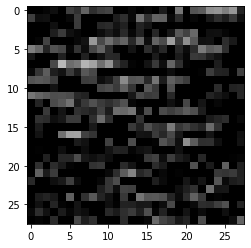

In [79]:
im = test_image[0].reshape((28,28))
im = np.stack([im,im,im],axis=-1)
from matplotlib import pyplot as plt
plt.imshow(im)